![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split   
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

season  holiday  workingday  weather  temp   atemp  \
datetime                                                                  
2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

                     humidity  windspeed  casual  registered  total  hour  
datetime                                                                   
2011-01-01 00:00:00        81        0.0       3          13     16     0  
2011-01-01 01:00:00        80        0.0       8          32     40     1  
2011-01-01 02:00:00        80        0.0       5          27     32     2  
2011-01-01 03:00:00        75        0.0       3          10     13     3  
2011-01-01 04:00:00        75        0.0       0           1      1     4

### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

In [5]:
bikes.groupby('season').total.describe()

count        mean         std  min   25%    50%    75%    max
season                                                                
1       2686.0  116.343261  125.273974  1.0  24.0   78.0  164.0  801.0
2       2733.0  215.251372  192.007843  1.0  49.0  172.0  321.0  873.0
3       2733.0  234.417124  197.151001  1.0  68.0  195.0  347.0  977.0
4       2734.0  198.988296  177.622409  1.0  51.0  161.0  294.0  948.0

#### Análisis variable Season:
Esta variable hace referencia a la estación del año, de la siguiente manera:
1. Invierno
2. Primavera
3. Verano
4. Otoño

De acuerdo a lo anterior se puede evidenciar que en promedio, la estación en la que más bicicletas son rentadas es el verano; la mayor cantidad de bicicletas rentadas en un día de verano fue de 977 y la mínima 1, de hecho, en todas las estaciones dentro del dataset la cantidad mínima de renta durante un día es de una bicicleta. Por otra parte, la estación en el que el servicio de bicicletas tiene una menor utilización promedio es el invierno, con una media de 116 y una mediana de 78, es decir, una asimetría hacia la derecha, lo cual puede deberse a datos atípicos que inflan el promedio (por ejemplo el máximo durante invierno que fue de 801 rentas).

En conclusión, la estación del año es una variable que afecta la demanda en la renta de bicicletas

In [6]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [7]:
bikes.groupby('hour').total.describe()

count        mean         std   min     25%    50%     75%    max
hour                                                                   
0     455.0   55.138462   43.620012   2.0   24.00   41.0   74.50  283.0
1     454.0   33.859031   34.112105   1.0   11.00   19.0   46.00  168.0
2     448.0   22.899554   26.110267   1.0    5.00   11.0   32.00  119.0
3     433.0   11.757506   12.666442   1.0    3.00    6.0   15.00   66.0
4     442.0    6.407240    4.217633   1.0    3.00    6.0    9.00   28.0
5     452.0   19.767699   12.784293   1.0    8.00   19.0   29.00   57.0
6     455.0   76.259341   54.745333   1.0   24.50   75.0  118.00  213.0
7     455.0  213.116484  159.207044   1.0   63.00  208.0  334.00  596.0
8     455.0  362.769231  231.723065   8.0  133.50  392.0  563.50  839.0
9     455.0  221.780220   92.099209  14.0  161.00  217.0  294.50  414.0
10    455.0  175.092308  101.807629  17.0  106.00  149.0  218.50  539.0
11    455.0  210.674725  127.444294  10.0  123.00  183.0  265.50  647.0
12    456.0  256.508772  143.881880   3.0  157.00  234.5  332.00  757.0
13    456.0  257.787281  149.167185  11.0  154.00  226.5  329.00  729.0
14    456.0  243.442982  147.563199  12.0  144.00  212.0  311.25  730.0
15    456.0  254.298246  144.235670   7.0  154.00  232.0  331.00  724.0
16    456.0  316.372807  145.664786  11.0  211.75  309.5  421.00  783.0
17    456.0  468.765351  223.775485  15.0  277.00  480.5  608.50  970.0
18    456.0  430.859649  219.908138  23.0  240.75  422.5  564.00  977.0
19    456.0  315.278509  156.641732  11.0  190.00  312.5  416.00  743.0
20    456.0  228.517544  116.411565  11.0  136.75  224.0  302.00  551.0
21    456.0  173.370614   87.629319   6.0  103.50  171.5  230.00  584.0
22    456.0  133.576754   69.844495   9.0   80.00  129.0  175.00  502.0
23    456.0   89.508772   51.638004   4.0   52.75   80.0  123.00  256.0

#### Análisis variable hour:
De acuerdo a los datos suministrados por el resumen de métricas cuantitativas, es posible identificar que durante el transcurrir del día el comportamiento de los alquileres de bicicletas varía dependiendo de la hora, es así como, por ejemplo, en altas horas de la noche y la madrugada, el alquiler disminuye considerablemente, por ejemplo a las 3 y 4 de la mañana podemos observar un promedio de alquiler de 11 y 6 bicicletas respectivamente, ambos con una mediana de 6, y una desviación estandar baja.

Por otra parte, horas como las 5 y 6 de la tarde tienen los mayores promedios con 468 y 430 bicicletas rentadas respectivamente y un máximo de 970 y 977 bicicletas en un día específico. Esto puede deberse a múltiples factores, por ejemplo horario de salida del trabajo de las personas y por ende requieren transporte para llegar a sus hogares.

En conclusión, al igual que la variable season, esta variable "hour" resulta crucial en la variación de la demanda de alquiler de bicicletas.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

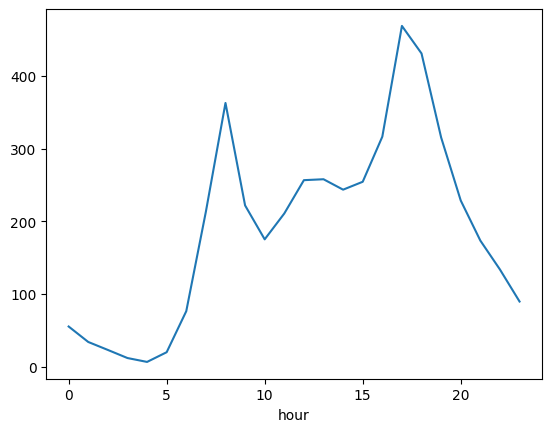

In [8]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<Axes: xlabel='hour'>

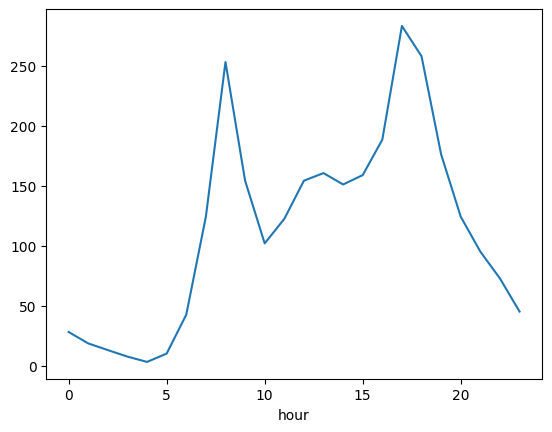

In [9]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes_invierno = bikes[bikes['season']==1]
bikes_invierno.groupby('hour').total.mean().plot()


<Axes: xlabel='hour'>

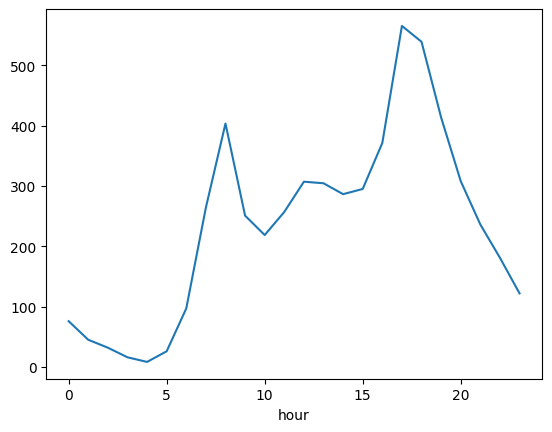

In [10]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes_verano = bikes[bikes['season']==3]
bikes_verano.groupby('hour').total.mean().plot()

De acuerdo a las gráficas anteriores, podemos ver cómo la tendencia a través de las horas es bastante similar en las tres gráficas. Si observamos bien, hay dos picos muy claros entre las 5 y las 10 am (aproximadamente 8:00 a.m.) y entre las 15 y las 20 horas (aproximadamente 5:00 p.m.). Si bien las tendencias son prácticamente las mismas, las proporciones son diferentes, teniendo en cuenta que en invierno el rango va de 0 a un poco más de 250, en verano va también desde 0 hasta un poco más de 500.

En conclusión se mantiene el mismo comportamiento a nivel de las líneas en los gráficos pero con diferentes valores dependiendo de la estación.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [11]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  total       10886 non-null  int64  
 11  hour        10886 non-null  int32  
dtypes: float64(3), int32(1), int64(8)
memory usage: 1.0 MB


In [12]:
bikes.reset_index(drop=True, inplace=True)

In [13]:
bikes['season'] = bikes['season'].astype('category')

In [14]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10886 non-null  category
 1   holiday     10886 non-null  int64   
 2   workingday  10886 non-null  int64   
 3   weather     10886 non-null  int64   
 4   temp        10886 non-null  float64 
 5   atemp       10886 non-null  float64 
 6   humidity    10886 non-null  int64   
 7   windspeed   10886 non-null  float64 
 8   casual      10886 non-null  int64   
 9   registered  10886 non-null  int64   
 10  total       10886 non-null  int64   
 11  hour        10886 non-null  int32   
dtypes: category(1), float64(3), int32(1), int64(7)
memory usage: 903.9 KB


In [15]:
bikes.head()

season  holiday  workingday  weather  temp   atemp  humidity  windspeed  \
0      1        0           0        1  9.84  14.395        81        0.0   
1      1        0           0        1  9.02  13.635        80        0.0   
2      1        0           0        1  9.02  13.635        80        0.0   
3      1        0           0        1  9.84  14.395        75        0.0   
4      1        0           0        1  9.84  14.395        75        0.0   

   casual  registered  total  hour  
0       3          13     16     0  
1       8          32     40     1  
2       5          27     32     2  
3       3          10     13     3  
4       0           1      1     4

In [16]:
# Celda 3
#Transformamos season en category, dado que estaba como Dtype = int64 y utilizamos get dummies para hacer el one-hot encode
bikes['season'] = bikes['season'].astype('category')
bikes = pd.get_dummies(bikes, columns=["season"])


In [17]:
bikes.head()

holiday  workingday  weather  temp   atemp  humidity  windspeed  casual  \
0        0           0        1  9.84  14.395        81        0.0       3   
1        0           0        1  9.02  13.635        80        0.0       8   
2        0           0        1  9.02  13.635        80        0.0       5   
3        0           0        1  9.84  14.395        75        0.0       3   
4        0           0        1  9.84  14.395        75        0.0       0   

   registered  total  hour  season_1  season_2  season_3  season_4  
0          13     16     0      True     False     False     False  
1          32     40     1      True     False     False     False  
2          27     32     2      True     False     False     False  
3          10     13     3      True     False     False     False  
4           1      1     4      True     False     False     False

In [18]:
#Utilizamos seasons (codificadas) y hour como variables predictoras y la variable y será total
X = bikes[['hour','season_1','season_2','season_3','season_4']]
y = bikes['total']

# #Realizamos división entre train y test, con un 20% de los datos para prueba
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state = 123)

# #Modelo de regresión usando la librería sklearn importada arriba y también entrenamos
reg = LinearRegression()
reg.fit(Xtrain, ytrain)

# #Hacemos las predicciones sobre test
pred_reg = reg.predict(Xtest)

# #Evaluamos rendimiento con mean squared erro
from sklearn.metrics import mean_squared_error
print('MSE: ',mean_squared_error(ytest, pred_reg))
print('Coeficiente de hour:', reg.coef_[0])
print('Coeficiente de season_1 (Invierno):', reg.coef_[1])
print('Coeficiente de season_2 (Primavera):', reg.coef_[2])
print('Coeficiente de season_3 (Verano):', reg.coef_[3])
print('Coeficiente de season_4 (Otoño):', reg.coef_[4])

MSE:  25129.16263183123
Coeficiente de hour: 10.58804133970049
Coeficiente de season_1 (Invierno): -76.4973563891207
Coeficiente de season_2 (Primavera): 24.810722918369663
Coeficiente de season_3 (Verano): 43.25647034570464
Coeficiente de season_4 (Otoño): 8.430163125046548


Text(0, 0.5, 'Promedio de bicicletas alquiladas (predicciones)')

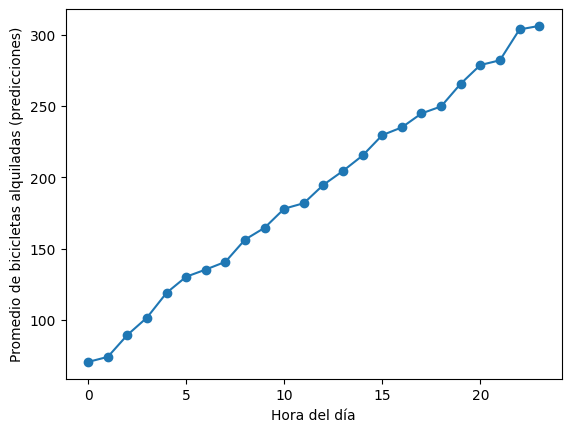

In [19]:
import matplotlib.pyplot as plt
predicciones_por_hora = Xtest.copy()
predicciones_por_hora['predicciones'] = pred_reg
predicciones_por_hora = predicciones_por_hora.groupby('hour')['predicciones'].mean()
predicciones_por_hora.plot(marker='o')
plt.xlabel('Hora del día')
plt.ylabel('Promedio de bicicletas alquiladas (predicciones)')

De acuerdo a lo anterior se logra evidenciar que los coeficientes son acordes a las estaciones, es decir, para el caso del coeficiente season_1 con un valor de -76, este afecta claramente en la reducción del total de bicicletas rentadas, teniendo en cuenta que en invierno es la estación en donde menos se rentan bicicletas; caso contrario sucede con season_3, en donde el coeficiente es positivo, 43, por lo que incrementa en 43 el número de bicicletas rentadas.

Por otra parte, cuando la variable 'hour' aumenta en una unidad, la variable de respuesta ('total') aumenta en aproximadamente 10.59 unidades, manteniendo constante el efecto de las variables de temporada.

Sin embargo, el problema es que el comportamiento de la renta de bicicletas no es lineal, es más estacionario/cambiante, dependiente de la hora del día y de múltiples factores, de hecho al graficar podemos ver como la gráfica no es muy cercana a la gráfica que inicialmente vimos, por lo que muy probablemente una regresión lineal no sea el mejor modelo a escoger.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [20]:
X.head()

hour  season_1  season_2  season_3  season_4
0     0      True     False     False     False
1     1      True     False     False     False
2     2      True     False     False     False
3     3      True     False     False     False
4     4      True     False     False     False

In [21]:
X

hour  season_1  season_2  season_3  season_4
0         0      True     False     False     False
1         1      True     False     False     False
2         2      True     False     False     False
3         3      True     False     False     False
4         4      True     False     False     False
...     ...       ...       ...       ...       ...
10881    19     False     False     False      True
10882    20     False     False     False      True
10883    21     False     False     False      True
10884    22     False     False     False      True
10885    23     False     False     False      True

[10886 rows x 5 columns]

In [22]:
X = X.astype(int)

In [23]:
X

hour  season_1  season_2  season_3  season_4
0         0         1         0         0         0
1         1         1         0         0         0
2         2         1         0         0         0
3         3         1         0         0         0
4         4         1         0         0         0
...     ...       ...       ...       ...       ...
10881    19         0         0         0         1
10882    20         0         0         0         1
10883    21         0         0         0         1
10884    22         0         0         0         1
10885    23         0         0         0         1

[10886 rows x 5 columns]

In [24]:
# En este caso no se calcula Gini index pq es un poblema de regresion y no de clasificación

# Definir función para calcular el error cuadrático medio (MSE)
def calculate_mse(y):
    if len(y) == 0:
        return 0
    return np.mean((y - np.mean(y))**2)

# Definir función para encontrar la mejor división de un nodo
def find_best_split(X, y):
    best_split_feature = None
    best_split_value = None
    best_mse = float('inf')
    
    for feature in X.columns:
        unique_values = np.unique(X[feature])
        for value in unique_values:
            left_indices = X[feature] <= value
            right_indices = ~left_indices
            
            left_mse = calculate_mse(y[left_indices])
            right_mse = calculate_mse(y[right_indices])
            
            mse = left_mse + right_mse
            
            if mse < best_mse:
                best_mse = mse
                best_split_feature = feature
                best_split_value = value
                
    return best_split_feature, best_split_value, best_mse

# Definir función para construir el árbol de decisión recursivamente
def build_tree(X, y, depth=0, max_depth=5, min_samples_split=2):
    # Verificar condiciones de parada
    if depth >= max_depth or len(X) < min_samples_split:
        return {'prediction': np.mean(y)}
    
    # Encontrar la mejor división
    best_split_feature, best_split_value, best_mse = find_best_split(X, y)
    
    # Verificar si no se puede hacer una división que reduzca el error
    if best_split_feature is None:
        return {'prediction': np.mean(y)}
    
    # Dividir el conjunto de datos en dos partes
    left_indices = X[best_split_feature] <= best_split_value
    right_indices = ~left_indices
    
    # Construir sub-árboles
    left_tree = build_tree(X[left_indices], y[left_indices], depth+1, max_depth, min_samples_split)
    right_tree = build_tree(X[right_indices], y[right_indices], depth+1, max_depth, min_samples_split)
    
    return {'split_feature': best_split_feature,
            'split_value': best_split_value,
            'left': left_tree,
            'right': right_tree}

# Definir función para realizar predicciones con el árbol de decisión
def tree_predict(X, tree):
    predicted = np.zeros(X.shape[0])
    
    for i, x in enumerate(X.values):
        node = tree
        while 'prediction' not in node:
            split_feature = node['split_feature']
            split_value = node['split_value']
            if x[X.columns.get_loc(split_feature)] <= split_value:
                node = node['left']
            else:
                node = node['right']
        predicted[i] = node['prediction']
    
    return predicted

# Construir el árbol de decisión
tree = build_tree(X, y)

# Realizar predicciones con el árbol de decisión
predictions = tree_predict(X, tree)

# Mostrar las primeras predicciones
print(predictions)


[ 25.17771982  25.17771982  25.17771982 ... 246.02523775 246.02523775
 246.02523775]


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [25]:
# Celda 5
# Se fdividen los datos en train y test, con un test del 20% de los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Se inicializa y entrena el decision tree regressorr
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
# Se predice
dtr_pred = dtr.predict(X_test)
# Se calcula mse
mse_dtr = mean_squared_error(y_test, dtr_pred)
print(mse_dtr)

13217.057890452617


In [26]:
# Celda 5
#Se hace lo mismo pero con un parámetro específico de min_impurity_decrease=0.001
dtr2 = DecisionTreeRegressor(min_impurity_decrease = 0.001)
dtr2.fit(X_train, y_train)
dtr2_pred = dtr2.predict(X_test)
mse_dtr2 = mean_squared_error(y_test, dtr2_pred)
print(mse_dtr2)

13216.904890488006


In [27]:
# Lista de valores para calibrar la profundidad máxima (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del MSE para cada valor de máxima profundidad (max_depth)
mse_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de regresión usando DecisionTreeRegressor de la librería sklearn
    dtr = DecisionTreeRegressor(max_depth=depth, random_state=1)
    dtr.fit(X_train, y_train)
    dtr_pred = dtr.predict(X_test)
    mse = mean_squared_error(y_test, dtr_pred)
    mse_scores.append(mse)

# Imprimir los resultados
for depth, mse in zip(max_depth_range, mse_scores):
    print("Max Depth:", depth, "| Mean Squared Error:", mse)

Max Depth: 1 | Mean Squared Error: 22332.742200527657
Max Depth: 2 | Mean Squared Error: 19809.52239444743
Max Depth: 3 | Mean Squared Error: 17250.213750981635
Max Depth: 4 | Mean Squared Error: 15649.216108823337
Max Depth: 5 | Mean Squared Error: 14709.002360642018
Max Depth: 6 | Mean Squared Error: 13383.8361233129
Max Depth: 7 | Mean Squared Error: 13237.6995659248
Max Depth: 8 | Mean Squared Error: 13273.233116446238
Max Depth: 9 | Mean Squared Error: 13217.36517212893
Max Depth: 10 | Mean Squared Error: 13217.057890452617
Max Depth: 11 | Mean Squared Error: 13217.057890452617
Max Depth: 12 | Mean Squared Error: 13217.057890452617
Max Depth: 13 | Mean Squared Error: 13217.057890452617
Max Depth: 14 | Mean Squared Error: 13217.057890452617
Max Depth: 15 | Mean Squared Error: 13217.057890452617
Max Depth: 16 | Mean Squared Error: 13217.057890452617
Max Depth: 17 | Mean Squared Error: 13217.057890452617
Max Depth: 18 | Mean Squared Error: 13217.057890452617
Max Depth: 19 | Mean Squa

Comparando el desempeño con el modelo del punto 3, vemos que existe una gran diferencia entre ambos MSE. Mientras que el MSE del modelo de regresión es de 25129.16263183123, el hallado con árboles de regresión es de 13216.904890488006 si lo tomamos con base en min_impurity_decrease o 13217.057890452617 si lo vemos con base en max_depth; una reducción del MSE prácticamente a la mitad, lo que quiere decir que el modelo con árboles de regresión tiene un mejor rendimiento en la predicción de la variable objetivo en comparación con el modelo de regresión lineal.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [28]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

url  timedelta  \
0  http://mashable.com/2014/12/10/cia-torture-rep...       28.0   
1  http://mashable.com/2013/10/18/bitlock-kicksta...      447.0   
2  http://mashable.com/2013/07/24/google-glass-po...      533.0   
3  http://mashable.com/2013/11/21/these-are-the-m...      413.0   
4  http://mashable.com/2014/02/11/parking-ticket-...      331.0   

   n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
0             9.0             188.0         0.732620               1.0   
1             7.0             297.0         0.653199               1.0   
2            11.0             181.0         0.660377               1.0   
3            12.0             781.0         0.497409               1.0   
4             8.0             177.0         0.685714               1.0   

   n_non_stop_unique_tokens  num_hrefs  num_self_hrefs  num_imgs  ...  \
0                  0.844262        5.0             1.0       1.0  ...   
1                  0.815789        9.0             4.0       1.0  ...   
2                  0.775701        4.0             3.0       1.0  ...   
3                  0.677350       10.0             3.0       1.0  ...   
4                  0.830357        3.0             2.0       1.0  ...   

   min_positive_polarity  max_positive_polarity  avg_negative_polarity  \
0               0.200000                   0.80              -0.487500   
1               0.160000                   0.50              -0.135340   
2               0.136364                   1.00               0.000000   
3               0.100000                   1.00              -0.195701   
4               0.100000                   0.55              -0.175000   

   min_negative_polarity  max_negative_polarity  title_subjectivity  \
0                  -0.60              -0.250000                 0.9   
1                  -0.40              -0.050000                 0.1   
2                   0.00               0.000000                 0.3   
3                  -0.40              -0.071429                 0.0   
4                  -0.25              -0.100000                 0.0   

   title_sentiment_polarity  abs_title_subjectivity  \
0                       0.8                     0.4   
1                      -0.1                     0.4   
2                       1.0                     0.2   
3                       0.0                     0.5   
4                       0.0                     0.5   

   abs_title_sentiment_polarity  Popular  
0                           0.8        1  
1                           0.1        0  
2                           1.0        0  
3                           0.0        0  
4                           0.0        0  

[5 rows x 61 columns]

In [29]:
# Definición variable de interes y variables predictoras
X_ = df.drop(['url', 'timedelta', 'Popular'], axis=1) #Eliminé adicionalmente timedelta al cosiderarse como no predictiva
y_ = df['Popular']
y_.mean()

0.5

In [30]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, random_state=1)

In [31]:
X_.columns

Index(['n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs',
       'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negat

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [32]:
# Celda 6
# Regresión logística

# Escalar las características
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
scaler = StandardScaler()
X_train_scaled_ = scaler.fit_transform(X_train_)
X_test_scaled_ = scaler.transform(X_test_)

# Inicializar y ajustar el modelo de regresión logística
model = LogisticRegression()
model.fit(X_train_scaled_, y_train_)

# Predecir en el conjunto de prueba
y_pred_ = model.predict(X_test_scaled_)

# Calcular métricas de desempeño
accuracy_ = accuracy_score(y_test_, y_pred_)
f1_ = f1_score(y_test_, y_pred_)

print("Accuracy regresión logística:", accuracy_)
print("F1 Score regresión logística:", f1_)

Accuracy regresión logística: 0.6393333333333333
F1 Score regresión logística: 0.6276668960770819


In [33]:
from sklearn.tree import DecisionTreeClassifier
# Definir el rango de valores para la profundidad máxima
max_depth_range = range(1, 10)

# Listas para almacenar los puntajes de precisión y F1
accuracy_scores = []
f1_scores = []

# Iterar sobre diferentes valores de profundidad máxima
for depth in max_depth_range:
    # Definición del árbol de decisión con la profundidad actual
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    
    # Ajustar el modelo y calcular las predicciones
    clf.fit(X_train_, y_train_)
    y_pred = clf.predict(X_test_)
    
    # Calcular la precisión y F1
    accuracy = accuracy_score(y_test_, y_pred)
    f1 = f1_score(y_test_, y_pred)
    
    # Agregar los puntajes a las listas
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

    print(f"Profundidad máxima: {depth}, Accuracy: {accuracy}, F1 Score: {f1}")

Profundidad máxima: 1, Accuracy: 0.6453333333333333, F1 Score: 0.6448598130841121
Profundidad máxima: 2, Accuracy: 0.6453333333333333, F1 Score: 0.6448598130841121
Profundidad máxima: 3, Accuracy: 0.6413333333333333, F1 Score: 0.6072992700729927
Profundidad máxima: 4, Accuracy: 0.6513333333333333, F1 Score: 0.6345213137665968


Profundidad máxima: 5, Accuracy: 0.6393333333333333, F1 Score: 0.6616635397123202
Profundidad máxima: 6, Accuracy: 0.6253333333333333, F1 Score: 0.6283068783068783
Profundidad máxima: 7, Accuracy: 0.6166666666666667, F1 Score: 0.6344564526382708
Profundidad máxima: 8, Accuracy: 0.61, F1 Score: 0.6290424857324033
Profundidad máxima: 9, Accuracy: 0.6073333333333333, F1 Score: 0.6226777706598334


El modelo de árboles de regresión tiene una precisión razonablemente alta y un F1 Score un poco mejor en comparación con el modelo de regresión logística

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

Nota: 

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [34]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, random_state=1)

# Creación de 300 muestras de bootstrap
n_estimators = 300
np.random.seed(123)
seeds = np.random.randint(1, 10000, size=n_estimators)
n_samples = X_train_.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_estimators)]

len(samples)

300

In [35]:
models = {}


# 100 modelos con árboles + max_depth
for i in range(0,100):
    models[i] = DecisionTreeClassifier(max_depth=6, random_state=seeds[i])
    models[i].fit(X_train_.iloc[samples[i]], y_train_.iloc[samples[i]])

# 100 modelos con árboles + min_samples_leaf
for i in range(100,200):
    models[i] = DecisionTreeClassifier(min_samples_leaf=10, random_state=seeds[i])
    models[i].fit(X_train_.iloc[samples[i]], y_train_.iloc[samples[i]])

# 100 modelos con regresión logística
for i in range(200,300):
    models[i] = LogisticRegression(random_state=seeds[i])
    models[i].fit(X_train_.iloc[samples[i]], y_train_.iloc[samples[i]])

In [36]:
y_pred_df = pd.DataFrame(index=X_test_.index, columns=range(n_estimators))

y_pred_df

0    1    2    3    4    5    6    7    8    9    ...  290  291  292  \
1483  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2185  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2520  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
3721  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
3727  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
3077  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
5166  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2227  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
5684  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
1937  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   

      293  294  295  296  297  298  299  
1483  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2185  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2520  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3721  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3727  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
...   ...  ...  ...  ...  ...  ...  ...  
3077  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
5166  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2227  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
5684  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1937  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[1500 rows x 300 columns]

In [37]:
# Predicción para los datos del set de test con cada modelo

for i in range(n_estimators):
    y_pred_df.iloc[:, i] = models[i].predict(X_test_)

y_pred_df.head()

0   1   2   3   4   5   6   7   8   9    ... 290 291 292 293 294 295 296  \
1483   1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   1   1   
2185   0   1   1   1   1   1   1   1   1   1  ...   0   0   0   0   0   1   0   
2520   1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   1   1   
3721   1   1   1   1   1   1   0   1   1   1  ...   1   1   1   1   1   1   1   
3727   0   0   0   0   0   0   1   0   0   0  ...   0   0   0   0   0   0   0   

     297 298 299  
1483   1   1   1  
2185   0   0   1  
2520   1   1   1  
3721   1   1   1  
3727   0   0   0  

[5 rows x 300 columns]

In [38]:
# Impresión de la cantidad de modelos que predijeron 1 para 10 observaciones
y_pred_df.sum(axis=1)[:10]

1483    280
2185    193
2520    239
3721    262
3727     39
4524    211
234      26
4735     56
5839    145
2939    199
dtype: object

In [39]:
y_pred_df

0   1   2   3   4   5   6   7   8   9    ... 290 291 292 293 294 295 296  \
1483   1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   1   1   
2185   0   1   1   1   1   1   1   1   1   1  ...   0   0   0   0   0   1   0   
2520   1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   1   1   
3721   1   1   1   1   1   1   0   1   1   1  ...   1   1   1   1   1   1   1   
3727   0   0   0   0   0   0   1   0   0   0  ...   0   0   0   0   0   0   0   
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
3077   0   0   0   0   1   0   1   1   0   0  ...   0   0   0   0   0   0   0   
5166   0   0   0   0   1   0   0   0   0   0  ...   0   0   1   0   0   0   0   
2227   1   1   1   1   0   1   1   1   1   1  ...   0   0   1   0   1   1   0   
5684   1   0   0   1   0   0   0   1   1   1  ...   0   0   0   0   0   0   0   
1937   0   0   0   1   0   0   0   0   0   1  ...   0   0   0   0   0   0   0   

     297 298 299  
1483   1   1   1  
2185   0   0   1  
2520   1   1   1  
3721   1   1   1  
3727   0   0   0  
...   ..  ..  ..  
3077   0   0   0  
5166   0   0   0  
2227   1   1   0  
5684   0   0   0  
1937   0   0   0  

[1500 rows x 300 columns]

In [40]:
# Votación mayoritaria
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(int)



In [41]:
y_pred

1483    1
2185    1
2520    1
3721    1
3727    0
       ..
3077    0
5166    0
2227    1
5684    0
1937    0
Length: 1500, dtype: int32

In [42]:
# Desempeño al hacer votación mayoritaria
f1_score(y_pred, y_test_)

0.6163182737693864

In [43]:
accuracy_score(y_test_, y_pred)


0.6206666666666667

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [44]:
# Celda 8
samples_oob = []
# Obtención de las observaciones fuera de la bolsa "out-of-bag" para cada muestra
for sample in samples:
    samples_oob.append(sorted(set(range(n_samples)) - set(sample)))

samples_oob

[[4,
  6,
  9,
  10,
  11,
  12,
  14,
  15,
  19,
  20,
  24,
  28,
  30,
  31,
  42,
  43,
  44,
  45,
  58,
  59,
  61,
  63,
  66,
  68,
  74,
  79,
  80,
  81,
  84,
  85,
  97,
  101,
  102,
  103,
  104,
  110,
  111,
  112,
  116,
  128,
  129,
  132,
  134,
  137,
  146,
  150,
  152,
  155,
  156,
  159,
  160,
  163,
  165,
  167,
  168,
  171,
  176,
  186,
  187,
  188,
  190,
  192,
  197,
  202,
  203,
  204,
  207,
  209,
  213,
  215,
  218,
  219,
  220,
  221,
  222,
  224,
  225,
  226,
  229,
  235,
  236,
  238,
  239,
  242,
  244,
  248,
  252,
  255,
  257,
  262,
  263,
  264,
  265,
  267,
  271,
  276,
  279,
  284,
  288,
  289,
  290,
  293,
  298,
  299,
  304,
  309,
  314,
  315,
  317,
  319,
  320,
  322,
  323,
  328,
  332,
  334,
  335,
  337,
  339,
  340,
  347,
  352,
  358,
  360,
  364,
  365,
  368,
  369,
  370,
  371,
  374,
  379,
  380,
  381,
  382,
  383,
  384,
  386,
  388,
  390,
  396,
  397,
  405,
  407,
  409,
  411,
  415,
  418

In [45]:
errors = np.zeros(n_estimators)

for i in range(n_estimators):
    y_pred_ = models[i].predict(X_train_.iloc[samples_oob[i]])
    errors[i] = 1 - accuracy_score(y_train_.iloc[samples_oob[i]], y_pred_)
errors

array([0.41905925, 0.40856269, 0.38809524, 0.39362354, 0.39522388,
       0.36918429, 0.39792809, 0.37418203, 0.40762813, 0.37507526,
       0.40243161, 0.40310078, 0.38153098, 0.40251196, 0.4015748 ,
       0.39459127, 0.39377618, 0.39416058, 0.40529164, 0.38415366,
       0.38316046, 0.39511323, 0.4009434 , 0.38555692, 0.3815237 ,
       0.39574468, 0.39691028, 0.39518497, 0.38246041, 0.40547112,
       0.40823743, 0.3965311 , 0.38256659, 0.43100304, 0.42435424,
       0.37007389, 0.41545894, 0.42274939, 0.41281139, 0.40204943,
       0.40168878, 0.40227137, 0.39697885, 0.38054187, 0.41548863,
       0.39429929, 0.38527085, 0.40625   , 0.41373134, 0.42478941,
       0.40210403, 0.39492754, 0.4021544 , 0.3697479 , 0.41712538,
       0.38580247, 0.40909091, 0.39056832, 0.39939024, 0.40933899,
       0.41258318, 0.38705812, 0.41014925, 0.41503667, 0.3974437 ,
       0.40558591, 0.4006079 , 0.39344262, 0.4010989 , 0.40740741,
       0.39738251, 0.41553637, 0.400849  , 0.38946724, 0.39464

Text(0.5, 1.0, 'OOB error of each tree')

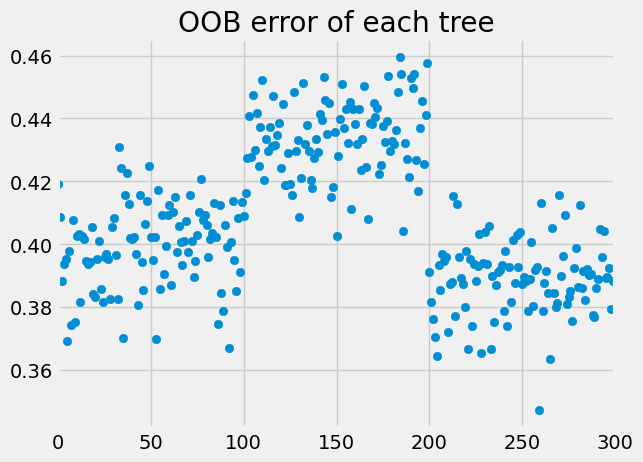

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

plt.scatter(range(n_estimators), errors)
plt.xlim([0, n_estimators])
plt.title('OOB error of each tree')

In [47]:
alpha = (1 - errors) / (1 - errors).sum()

In [48]:
weighted_sum_1 = ((y_pred_df) * alpha).sum(axis=1)
weighted_sum_1.head(20)

1483    0.936517
2185    0.645517
2520    0.804103
3721    0.877046
3727    0.125822
4524    0.709651
234     0.084148
4735    0.183181
5839    0.484995
2939     0.66899
3053    0.877385
867     0.841637
276     0.832064
5798    0.112456
3512    0.935688
5789    0.067941
3198    0.795525
5908    0.915975
5718     0.26655
2687    0.087238
dtype: object

In [49]:
# Desempeño al hacer votación ponderada
# y_pred_ = (weighted_sum_1 >= 0.5).astype(int)
# f1_score(y_pred_, y_test_)

y_pred = (weighted_sum_1 >= 0.5).astype(int)
f1_score(y_pred, y_test_) 


0.6163182737693864

In [50]:
accuracy_score(y_pred, y_test_)

0.6206666666666667

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

Al comparar los resultados del accuracy score y el f1 score entre ambos modelos, podemos observar que son exactamente iguales, por lo que en este caso específico se puede utilizar cualquiera de los dos, sin embargo, de manera sorprendente el mejor modelo es el de DecisionTreeClassifier, con unas métricas de desempeño un poco mejores.